In [ ]:
# pip install pandas numpy scikit-learn matplotlib tensorflow

In [1]:
import pandas as pd
import numpy as np
import IPython
import IPython.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, Flatten, Attention
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [2]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPricesMerged.csv')

In [3]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
data.head()

,Price,neg_oil,neu_oil,pos_oil,compound_oil,neg_war,neu_war,pos_war,compound_war
Date,,,,,,,,,
2023-04-03,84.930000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-04,84.940002,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-05,84.989998,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-06,85.120003,0.000,0.000,0.000,0.0000,0.000,0.776,0.224,0.9866
2023-04-10,84.180000,0.086,0.816,0.098,0.9796,0.144,0.708,0.147,-0.1356


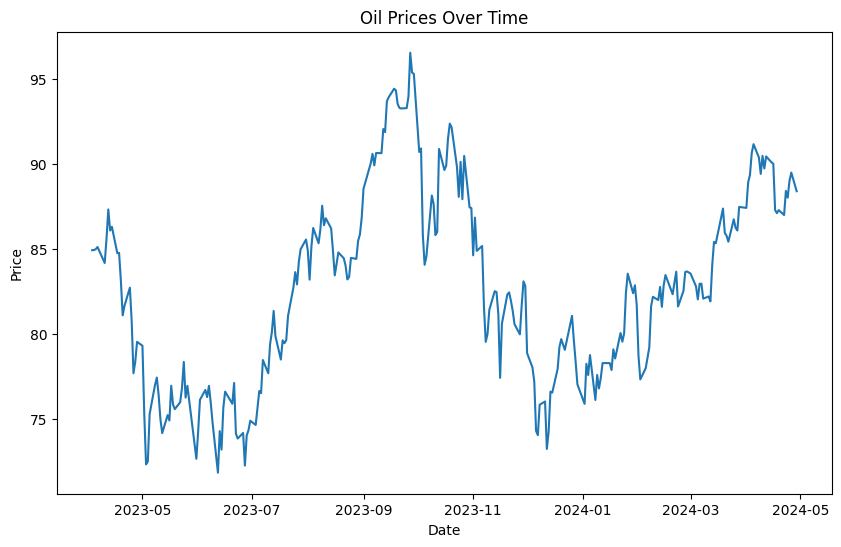

In [5]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [6]:
# Extract the relevant columns for oil sentiment data
# oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
# oil_data = data[['Price']]
oil_data = data[['Price', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
oil_data.head()

,Price,neg_war,neu_war,pos_war,compound_war
Date,,,,,
2023-04-03,84.930000,0.000,0.000,0.000,0.0000
2023-04-04,84.940002,0.000,0.000,0.000,0.0000
2023-04-05,84.989998,0.000,0.000,0.000,0.0000
2023-04-06,85.120003,0.000,0.776,0.224,0.9866
2023-04-10,84.180000,0.144,0.708,0.147,-0.1356


In [ ]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))
# oil_data = scaler.fit_transform(oil_data)

n = len(oil_data)
train_df = oil_data[0:int(n*0.7)]
val_df = oil_data[int(n*0.7):int(n*0.875)]
test_df = oil_data[int(n*0.875):]

In [8]:
len(train_df),len(val_df),len(test_df)

(189, 48, 34)

In [9]:
train_df.columns

Index(['Price', 'neg_war', 'neu_war', 'pos_war', 'compound_war'], dtype='object')

In [10]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [11]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [12]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=1,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [13]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def all_data(self):
  return self.make_dataset(oil_data)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.all_data = all_data
WindowGenerator.example = example

In [14]:
val_performance = {}
performance = {}
histories={}
models_list={}
windows_list={}

windows_dictionary = {
    'weekly': 7, 
    'bi-weekly': 14, 
    'monthly': 30,       
}


In [15]:
for w in windows_dictionary:
    input_width=windows_dictionary[w]
    window = WindowGenerator(
        input_width=input_width, label_width=1, shift=1,
        label_columns=['Price']
    )
    windows_list[w]=window

In [16]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, early_patience=10, lr_patience=5):
  # Define the callbacks with the current parameters
  early_stopping = EarlyStopping(monitor='val_loss', patience=early_patience, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=lr_patience)
  callbacks = [early_stopping, reduce_lr]

  model.compile(
    # loss='mean_absolute_percentage_error',
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=[
      tf.keras.metrics.MeanAbsolutePercentageError(),
      # tf.keras.metrics.MeanSquaredError()
      tf.keras.metrics.MeanAbsoluteError(),
    ]
  )

  history = model.fit(
    window.train, 
    epochs=MAX_EPOCHS, 
    validation_data=window.val,
    callbacks=callbacks
  )

  return history

In [17]:
train_df.shape

(189, 5)

In [17]:
#best LSTM model -  get_bidirectional_lstm_model_4
def get_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model


In [18]:
# best cnn model - 1D CNN with Residual Connections
from tensorflow.keras.layers import Add

def get_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    residual = Conv1D(filters=64, kernel_size=1, padding='same')(inputs)
    x = Add()([x, residual])
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model



In [19]:
def get_average_ensemble_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    model1 = get_lstm_model(input_shape)
    model2 = get_cnn_model(input_shape)

    y1 = model1(inputs)
    y2 = model2(inputs)
    
    outputs = layers.average([y1, y2])
    ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
    return ensemble_model

In [20]:
def get_concatenate_ensemble_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    model1 = get_lstm_model(input_shape)
    model2 = get_cnn_model(input_shape)

    y1 = model1(inputs)
    y2 = model2(inputs)
    
    ensemble_model=layers.concatenate([y1, y2])
    layer_1 = Dense(units=64, activation='relu')(ensemble_model)
    layer_2 = Dense(units=32, activation='relu')(layer_1)
    layer_3 = Dense(units=8, activation='relu')(layer_2)

    outputs = Dense(units=1, activation='relu')(layer_3)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [21]:
models_name_list={
    'lstm_model' : get_lstm_model,
    'cnn_model' : get_cnn_model,
    'average_ensemble_model' : get_average_ensemble_model ,
    'concatenate_ensemble_model' : get_concatenate_ensemble_model ,
}
models_list={}

In [22]:
for model_type in models_name_list:
    print(model_type)

lstm_model
cnn_model
average_ensemble_model
concatenate_ensemble_model


In [23]:
def create_model_for_each_model_type(model_type):
    for window_name in windows_dictionary:
        seq_length=windows_dictionary[window_name]
        window = windows_list[window_name]
        input_shape=(seq_length, train_df.shape[1])


        model_name=f'{model_type}_{window_name}'
        print('\n\n\n--------------',model_name, input_shape, '--------------')
        model = models_name_list[model_type](input_shape)
        print(model.summary())
        
        models_list[model_name]= {
            'model':model,
            'window':window,
            'seq_length':seq_length

        }


In [24]:
for model_type in models_name_list:
    print('\n------------',model_type,'------------')
    create_model_for_each_model_type(model_type)


------------ lstm_model ------------



-------------- lstm_model_weekly (7, 5) --------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 7, 100)            22400     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               60400     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                          

In [25]:
models_list

{'lstm_model_weekly': {'model': <keras.src.engine.sequential.Sequential at 0x1dc0d4c8350>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7]
  Label column name(s): ['Price'],
  'seq_length': 7},
 'lstm_model_bi-weekly': {'model': <keras.src.engine.sequential.Sequential at 0x1dc0d4cae90>,
  'window': Total window size: 15
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Label indices: [14]
  Label column name(s): ['Price'],
  'seq_length': 14},
 'lstm_model_monthly': {'model': <keras.src.engine.sequential.Sequential at 0x1dc10365910>,
  'window': Total window size: 31
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
   24 25 26 27 28 29]
  Label indices: [30]
  Label column name(s): ['Price'],
  'seq_length': 30},
 'cnn_model_weekly': {'model': <keras.src.engine.functional.Functional at 0x1dc1053e8d0>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7]
  Label

In [26]:
len(models_list)

12

In [27]:
for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    
    print('\n\n\n------------',model_name,'------------')
    history = compile_and_fit(model, window)

    histories[model_name] = history
    print('------------val performance')
    val_performance[model_name] = model.evaluate(window.val, return_dict=True)
    print('------------test performance')
    performance[model_name] = model.evaluate(window.test, verbose=1, return_dict=True)




------------ lstm_model_weekly ------------
Epoch 1/100
182/182 [==============================] - 10s 13ms/step - loss: 0.0280 - mean_absolute_percentage_error: 1020006.7500 - mean_absolute_error: 0.1344 - val_loss: 0.0382 - val_mean_absolute_percentage_error: 43.3217 - val_mean_absolute_error: 0.1775 - lr: 0.0010
Epoch 2/100
182/182 [==============================] - 1s 4ms/step - loss: 0.0293 - mean_absolute_percentage_error: 665607.0625 - mean_absolute_error: 0.1397 - val_loss: 0.0297 - val_mean_absolute_percentage_error: 38.2795 - val_mean_absolute_error: 0.1562 - lr: 0.0010
Epoch 3/100
182/182 [==============================] - 1s 4ms/step - loss: 0.0286 - mean_absolute_percentage_error: 830394.0000 - mean_absolute_error: 0.1394 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 30.8739 - val_mean_absolute_error: 0.1280 - lr: 0.0010
Epoch 4/100
182/182 [==============================] - 1s 5ms/step - loss: 0.0280 - mean_absolute_percentage_error: 754322.6250 - mean_absol

## evaluate

In [28]:
histories

{'lstm_model_weekly': <keras.src.callbacks.History at 0x1dc13c97310>,
 'lstm_model_bi-weekly': <keras.src.callbacks.History at 0x1dc1ba5dd50>,
 'lstm_model_monthly': <keras.src.callbacks.History at 0x1dc258a3250>,
 'cnn_model_weekly': <keras.src.callbacks.History at 0x1dc249f3ed0>,
 'cnn_model_bi-weekly': <keras.src.callbacks.History at 0x1dc2f43c310>,
 'cnn_model_monthly': <keras.src.callbacks.History at 0x1dc30a6bed0>,
 'average_ensemble_model_weekly': <keras.src.callbacks.History at 0x1dc3413a850>,
 'average_ensemble_model_bi-weekly': <keras.src.callbacks.History at 0x1dc3efdcdd0>,
 'average_ensemble_model_monthly': <keras.src.callbacks.History at 0x1dc493785d0>,
 'concatenate_ensemble_model_weekly': <keras.src.callbacks.History at 0x1dc53ae8550>,
 'concatenate_ensemble_model_bi-weekly': <keras.src.callbacks.History at 0x1dc5f70e1d0>,
 'concatenate_ensemble_model_monthly': <keras.src.callbacks.History at 0x1dc6a4aaa90>}

In [29]:
len(histories)

12

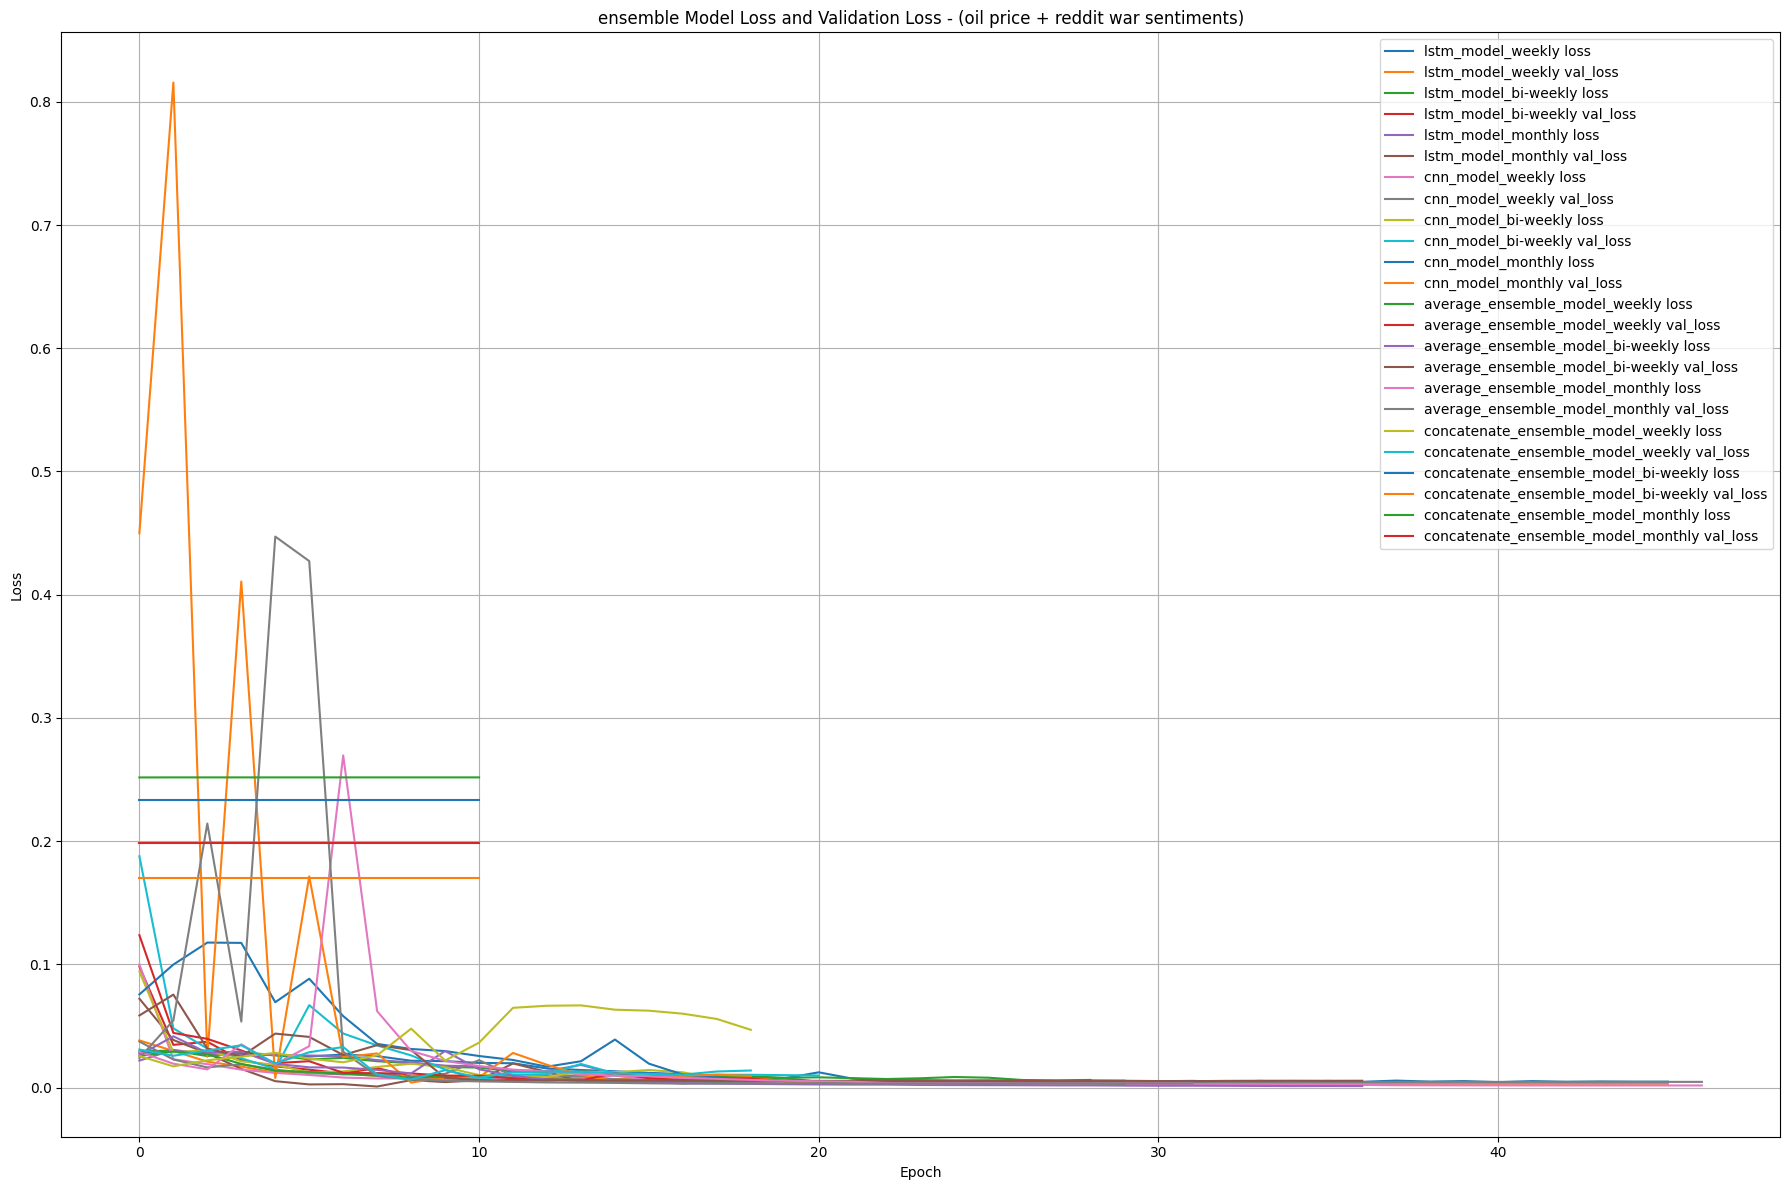

In [31]:
plt.figure(figsize=(18, 12))
for h in (histories):    # Plot Train vs Test Loss
    history=histories[h]
    plt.plot(history.history['loss'], label=f'{h} loss')
    plt.plot(history.history['val_loss'], label=f'{h} val_loss')

plt.title('ensemble Model Loss and Validation Loss - (oil price + reddit war sentiments)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil_reddit_war/ensemble model loss all models.png')

In [32]:
val_performance

{'lstm_model_weekly': {'loss': 0.002888450864702463,
  'mean_absolute_percentage_error': 12.111692428588867,
  'mean_absolute_error': 0.04174991324543953},
 'lstm_model_bi-weekly': {'loss': 0.00402631564065814,
  'mean_absolute_percentage_error': 13.746508598327637,
  'mean_absolute_error': 0.05125054344534874},
 'lstm_model_monthly': {'loss': 0.0008009750745259225,
  'mean_absolute_percentage_error': 4.73333215713501,
  'mean_absolute_error': 0.02068241685628891},
 'cnn_model_weekly': {'loss': 0.00445091538131237,
  'mean_absolute_percentage_error': 15.956714630126953,
  'mean_absolute_error': 0.05523049086332321},
 'cnn_model_bi-weekly': {'loss': 0.006375107914209366,
  'mean_absolute_percentage_error': 17.370569229125977,
  'mean_absolute_error': 0.06521393358707428},
 'cnn_model_monthly': {'loss': 0.003994481172412634,
  'mean_absolute_percentage_error': 12.838418960571289,
  'mean_absolute_error': 0.05678705498576164},
 'average_ensemble_model_weekly': {'loss': 0.00505237653851509

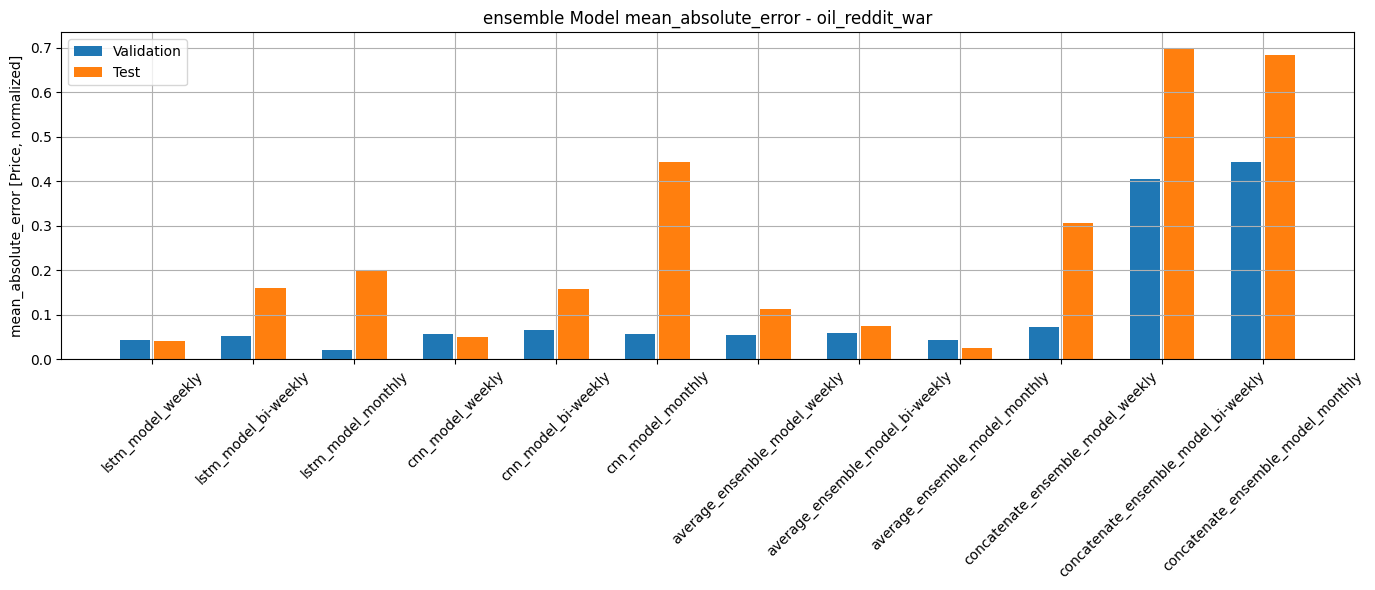

In [33]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.figure(figsize=(14, 6))
plt.title('ensemble Model mean_absolute_error - oil_reddit_war')
plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil_reddit_war/ensemble mean_absolute_error all models oil_reddit_war.png')


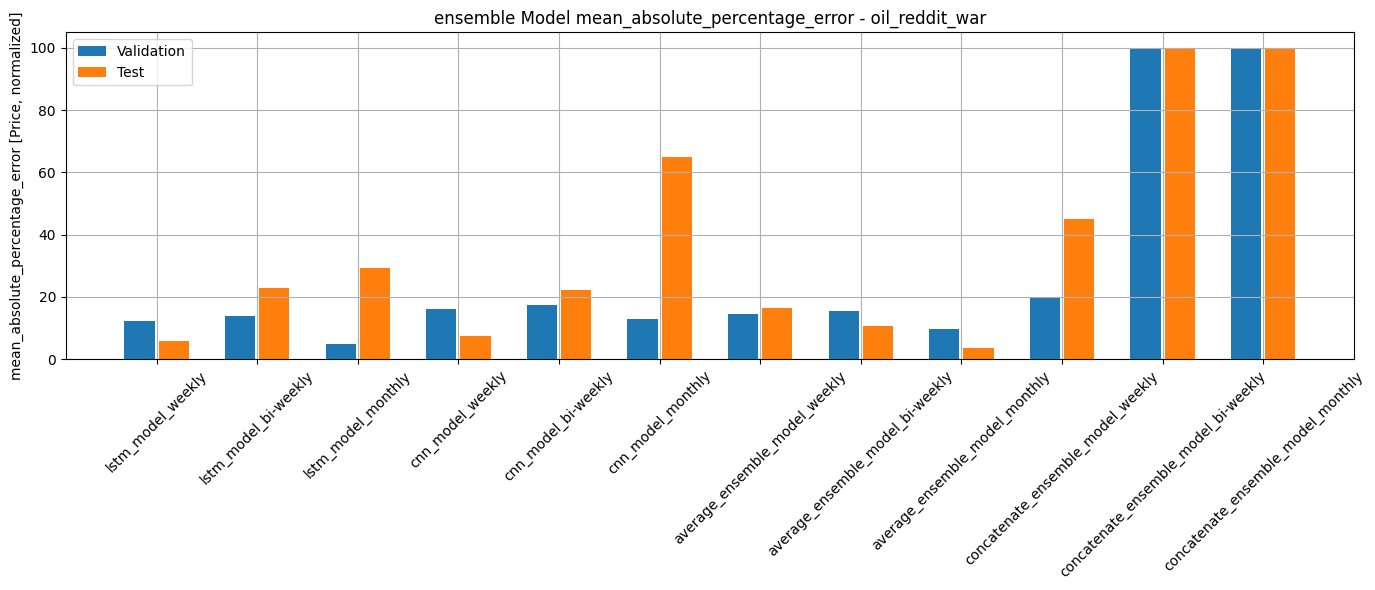

In [34]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_percentage_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('ensemble Model mean_absolute_percentage_error - oil_reddit_war')
plt.ylabel('mean_absolute_percentage_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil_reddit_war/ensemble mean_absolute_percentage_error all models oil_reddit_war.png')

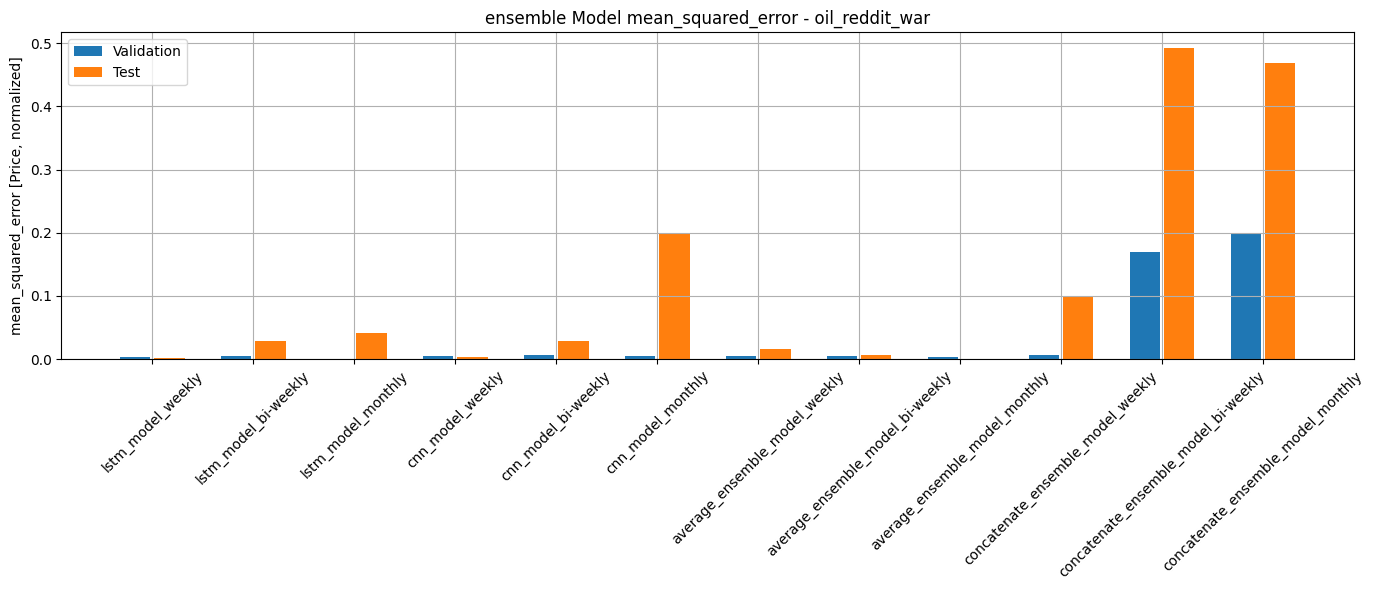

In [35]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error '
val_mae = [v['loss'] for v in val_performance.values()]
test_mae = [v['loss'] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('ensemble Model mean_squared_error - oil_reddit_war')
plt.ylabel('mean_squared_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil_reddit_war/ensemble mean_squared_error all models oil_reddit_war.png')

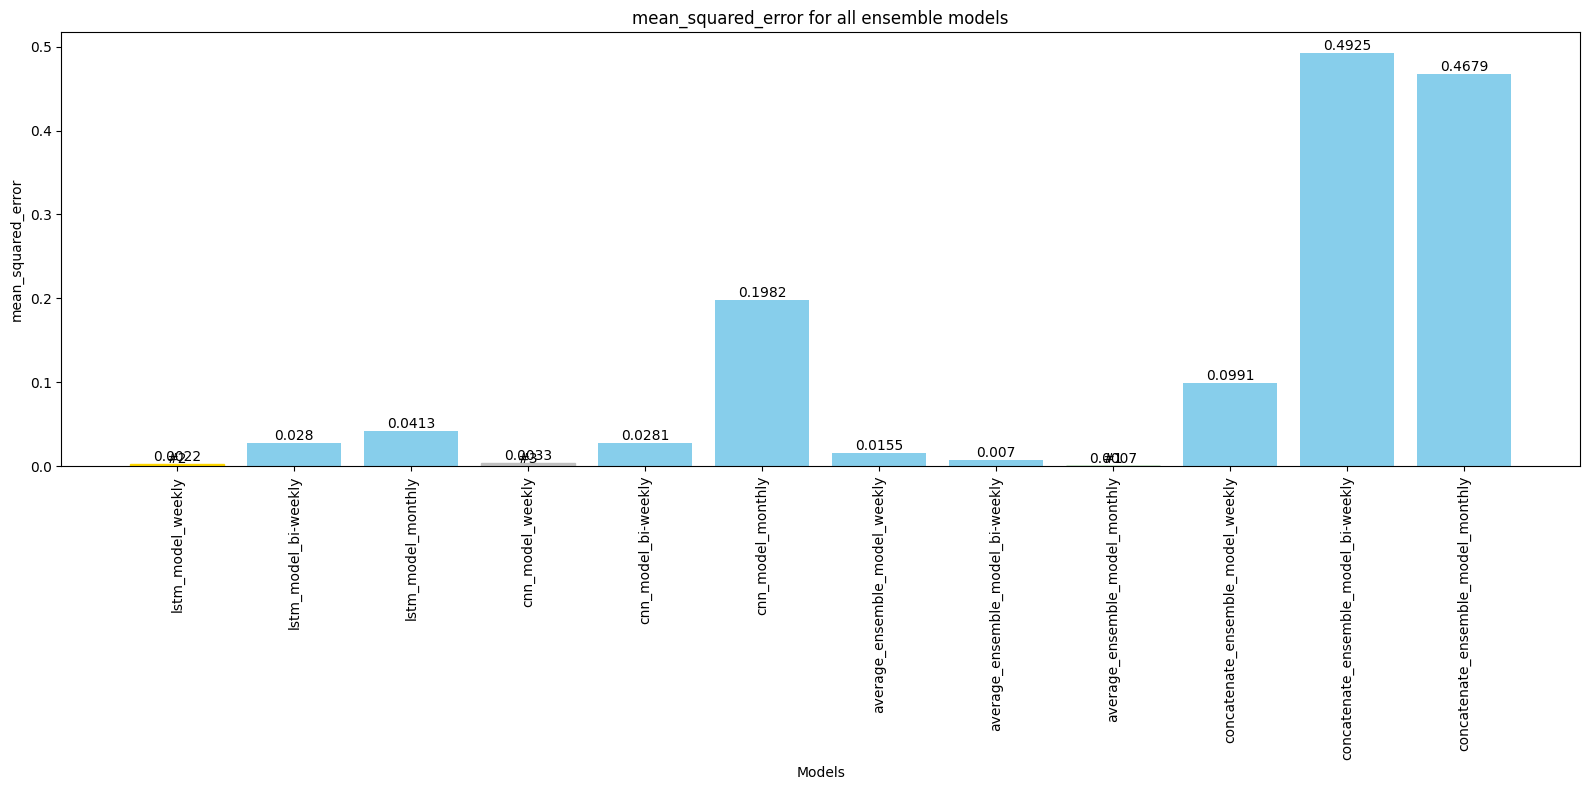

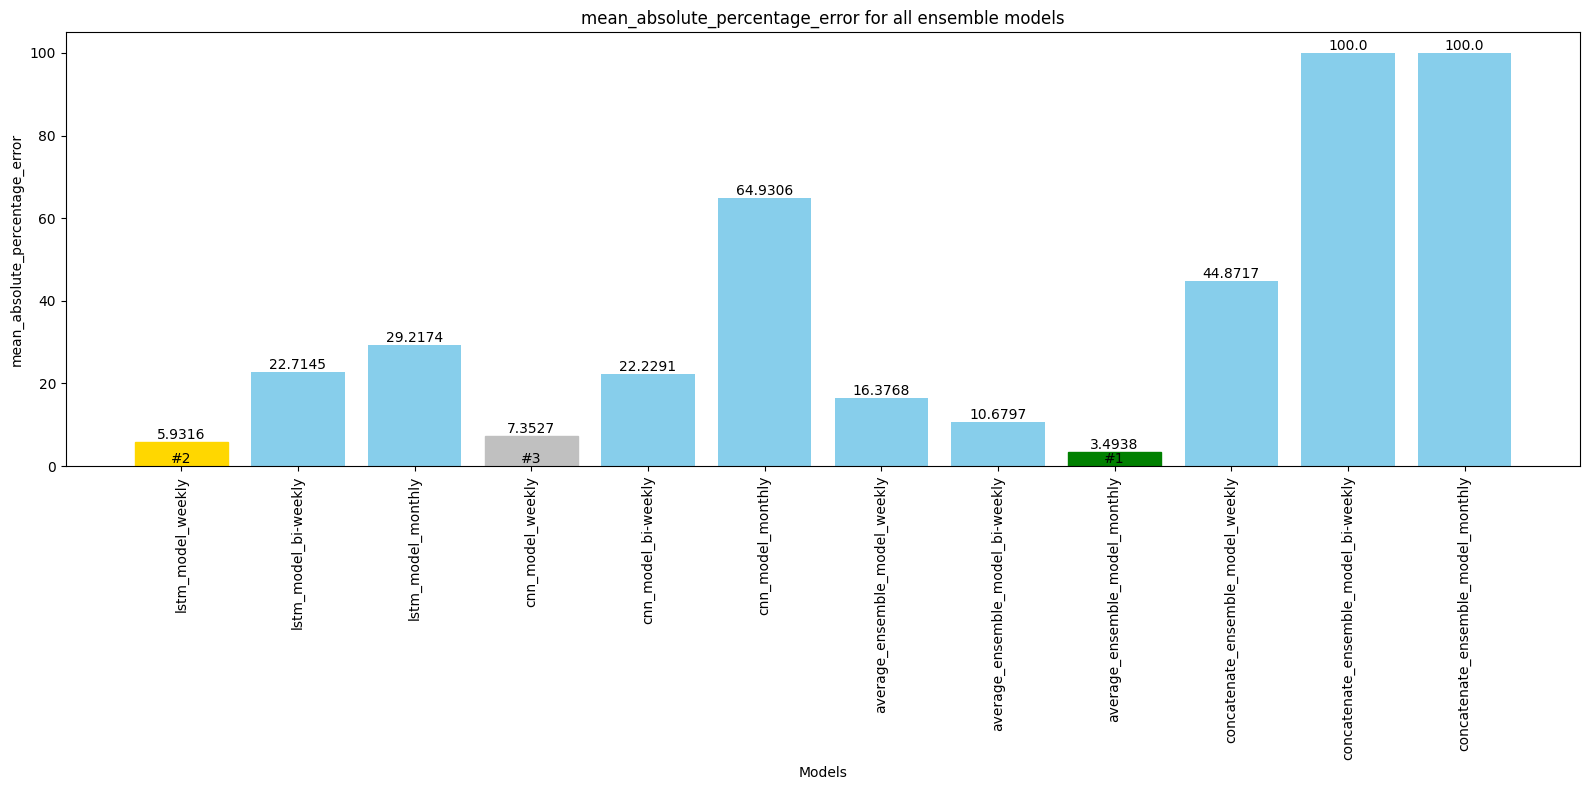

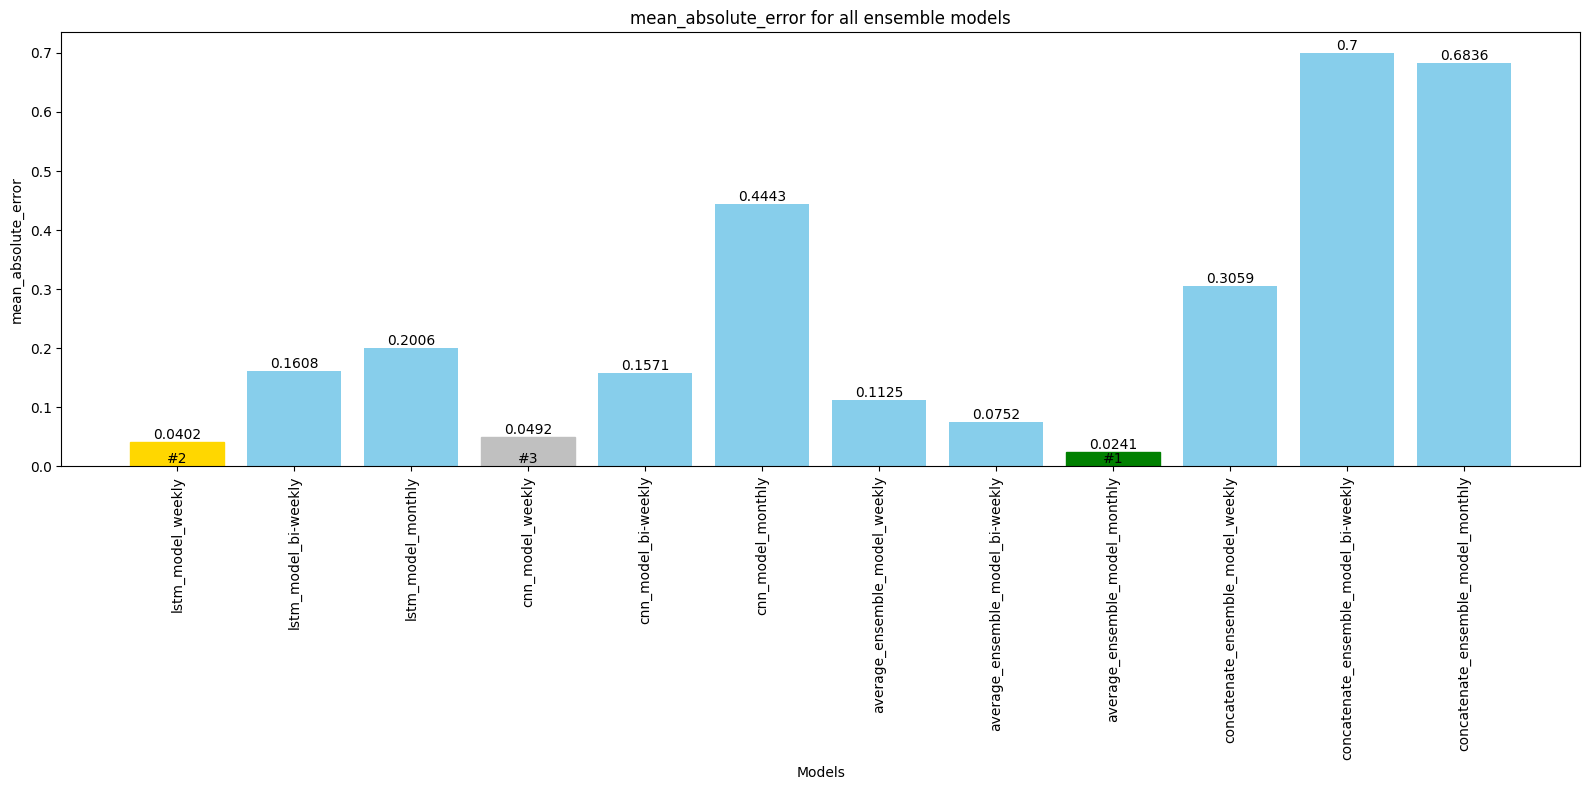

Top 3 models with minimum loss: ['average_ensemble_model_monthly', 'lstm_model_weekly', 'cnn_model_weekly']
Top 3 models with minimum mean_absolute_error: ['average_ensemble_model_monthly', 'lstm_model_weekly', 'cnn_model_weekly']
Top 3 models with minimum mean_squared_error: ['average_ensemble_model_monthly', 'lstm_model_weekly', 'cnn_model_weekly']


In [36]:
# Extract data for each metric
models = list(performance.keys())
loss_values = [performance[model]['loss'] for model in models]
mae_values = [performance[model]['mean_absolute_percentage_error'] for model in models]
mse_values = [performance[model]['mean_absolute_error'] for model in models]

# Function to plot and save a metric, highlighting the best model
def plot_and_save_metric(metric_values, metric_name, best_models_indices):
    plt.figure(figsize=(16, 8))
    bars = plt.bar(models, metric_values, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for all ensemble models')
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Highlight the best models with different colors
    colors = ['green', 'gold', 'silver']
    for rank, index in enumerate(best_models_indices):
        bars[index].set_color(colors[rank])
        yval = bars[index].get_height()

        plt.text(bars[index].get_x() + bars[index].get_width()/2,  0, f'#{rank+1}', ha='center', va='bottom')

    # Annotate all bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    plt.savefig(f'outputs/oil_reddit_war/ensemble {metric_name}_comparison oil_reddit_war.png')
    plt.show()

# Find the indices of the top 3 models with the minimum values for each metric
top_n = 3

min_loss_indices = np.argsort(loss_values)[:top_n]
min_mae_indices = np.argsort(mae_values)[:top_n]
min_mse_indices = np.argsort(mse_values)[:top_n]
# Plot and save loss
plot_and_save_metric(loss_values, 'mean_squared_error', min_loss_indices)

# Plot and save mean_absolute_error
plot_and_save_metric(mae_values, 'mean_absolute_percentage_error', min_mae_indices)

# Plot and save mean_squared_error
plot_and_save_metric(mse_values, 'mean_absolute_error', min_mse_indices)

# Get the model names for the top 3 models
min_loss_models = [models[i] for i in min_loss_indices]
min_mae_models = [models[i] for i in min_mae_indices]
min_mse_models = [models[i] for i in min_mse_indices]

print(f'Top {top_n} models with minimum loss: {min_loss_models}')
print(f'Top {top_n} models with minimum mean_absolute_error: {min_mae_models}')
print(f'Top {top_n} models with minimum mean_squared_error: {min_mse_models}')

In [37]:
model_name='concatenate_ensemble_model_bi-weekly' 
model = models_list[model_name]['model']
window = models_list[model_name]['window']
seq_length = models_list[model_name]['seq_length']

In [38]:
window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['Price']

In [39]:
seq_length

14

In [40]:
all_predict = model.predict(window.all_data)
print(all_predict.shape)

257/257 [==============================] - 2s 2ms/step
(257, 1)


In [41]:
all_predict[0]

array([0.], dtype=float32)

264/264 [==============================] - 2s 1ms/step


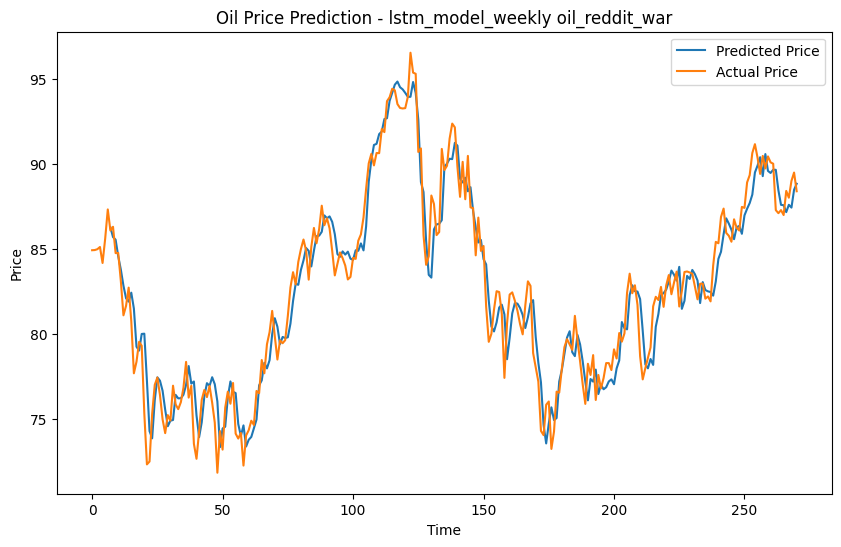

257/257 [==============================] - 2s 2ms/step


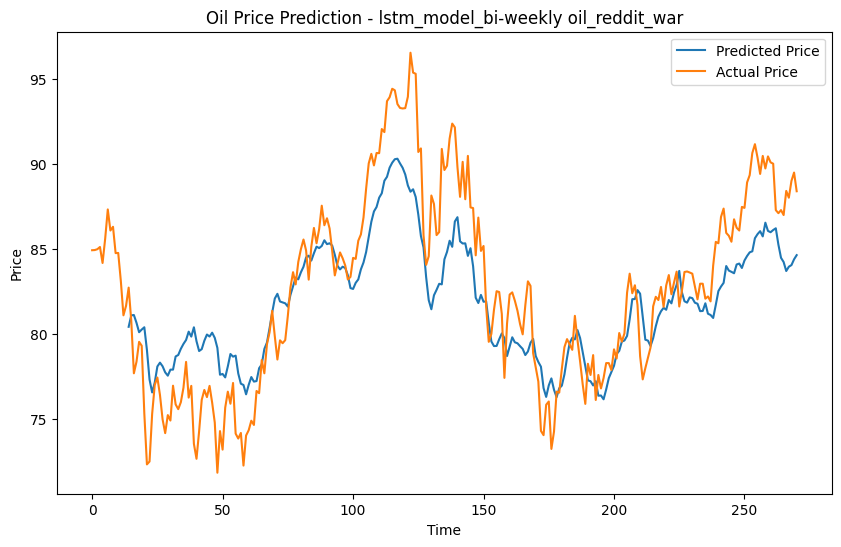

241/241 [==============================] - 2s 3ms/step


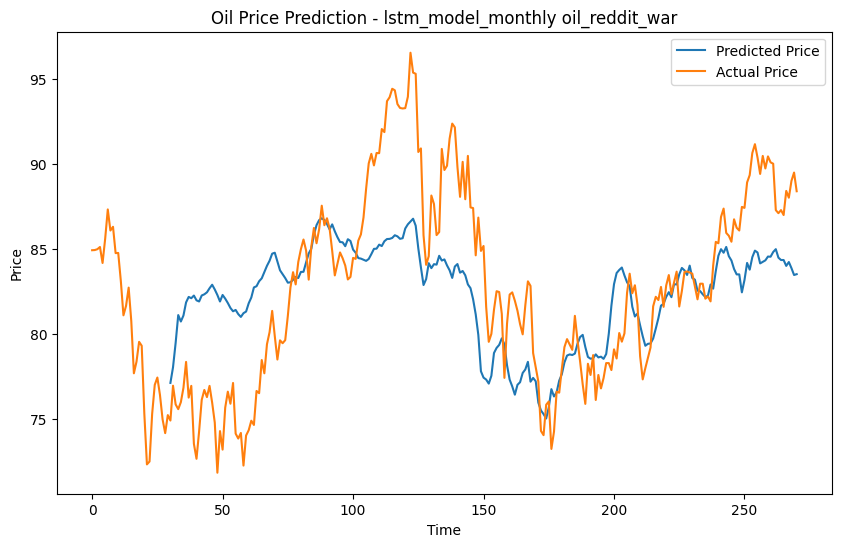

264/264 [==============================] - 0s 717us/step


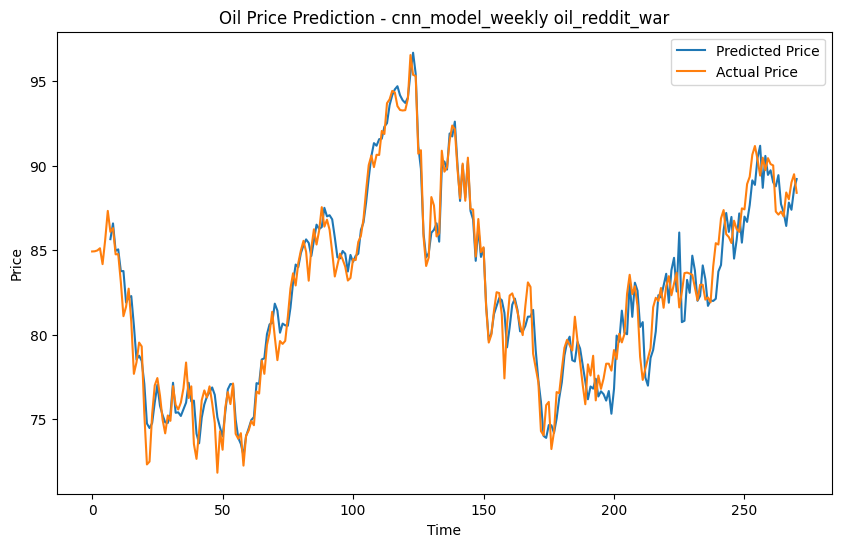

257/257 [==============================] - 0s 692us/step


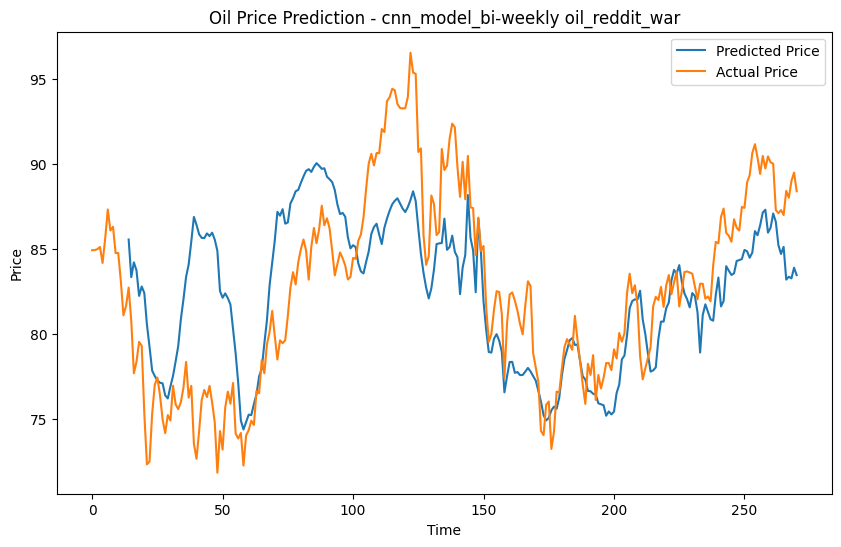

241/241 [==============================] - 0s 919us/step


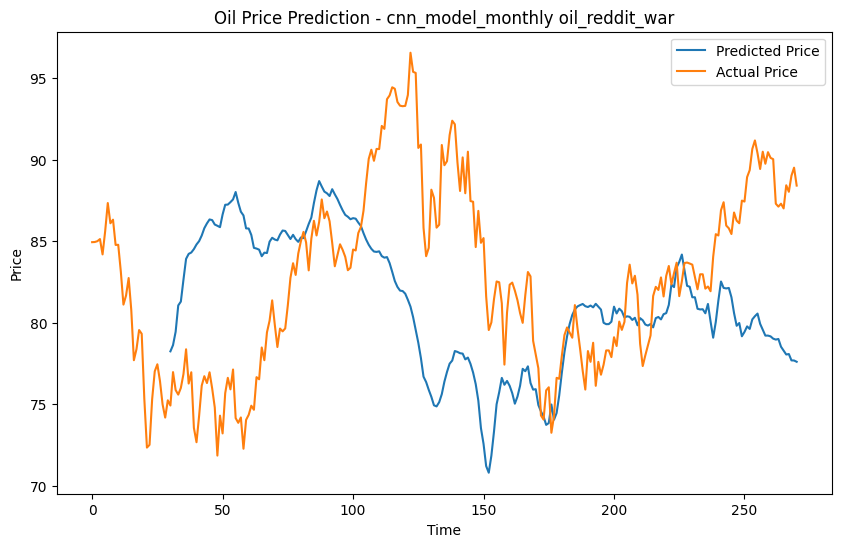

264/264 [==============================] - 2s 1ms/step


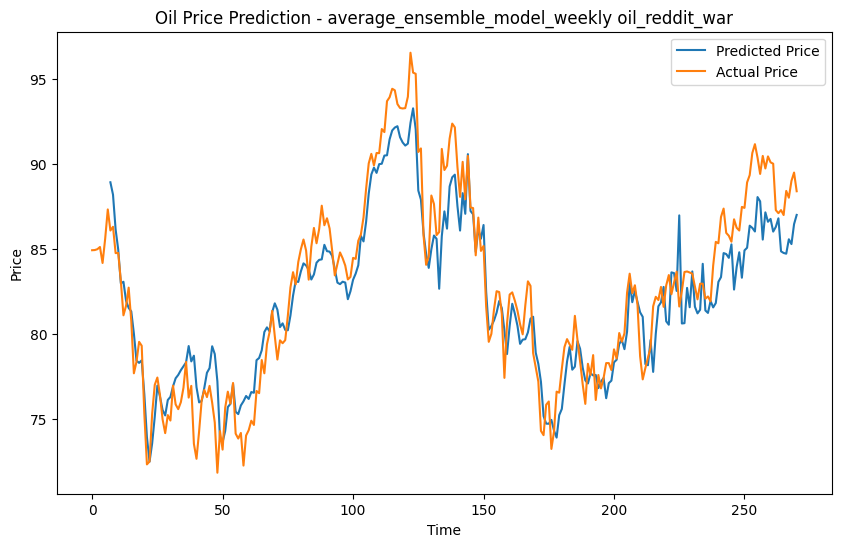

257/257 [==============================] - 2s 2ms/step


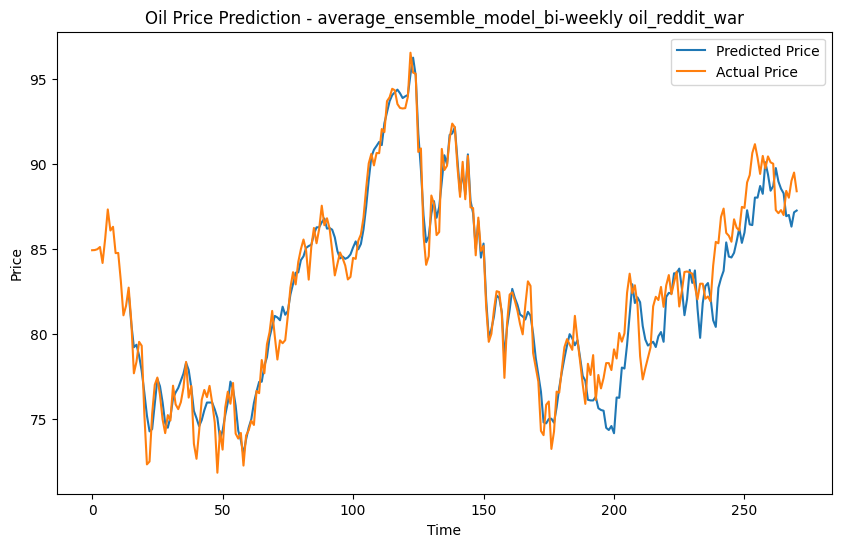

241/241 [==============================] - 2s 3ms/step


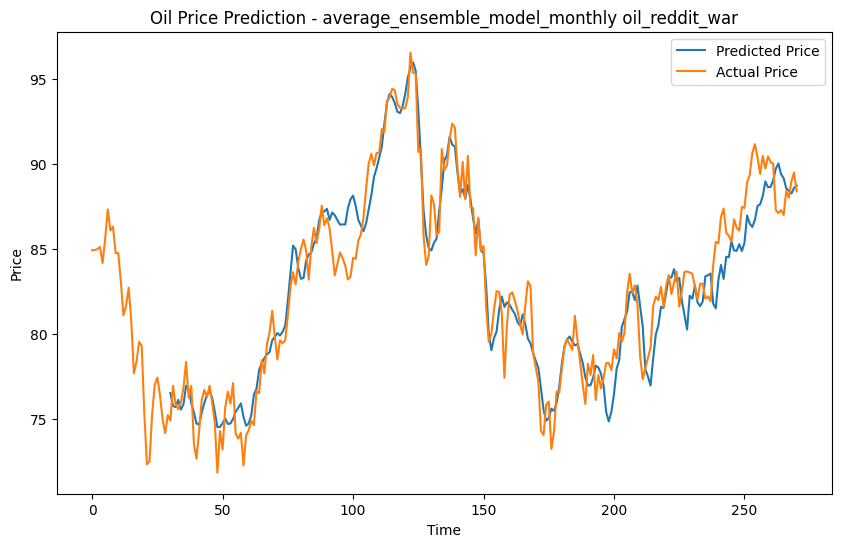

264/264 [==============================] - 2s 2ms/step


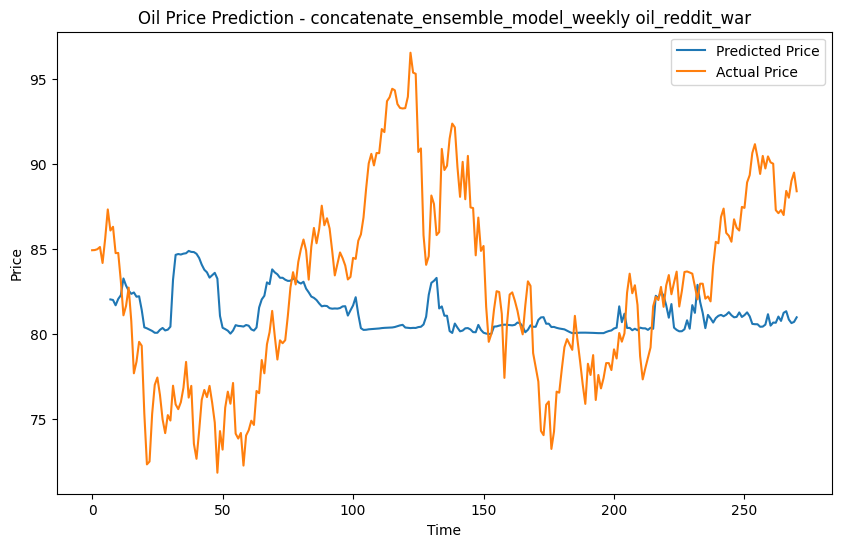

257/257 [==============================] - 1s 2ms/step


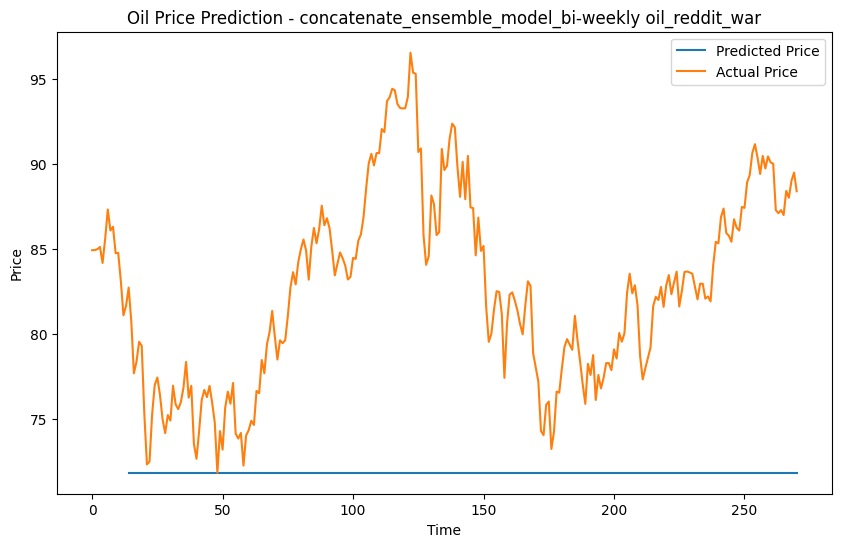

241/241 [==============================] - 3s 3ms/step


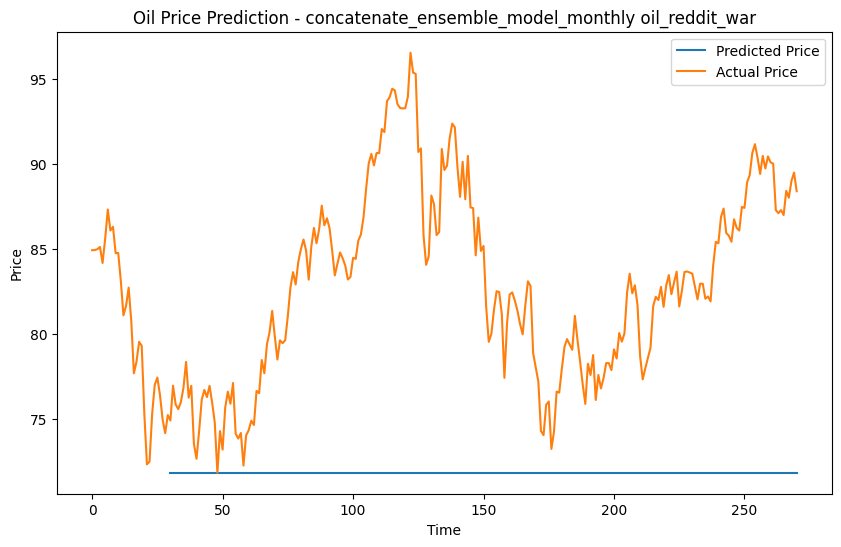

In [42]:
# Plot predictions vs actual values

# Y_test = np.array([s[1][0][0][0].numpy() for s in iter(window.test)])
Y_all_data = oil_data['Price'].values
Y_all_data = scaler.inverse_transform(Y_all_data.reshape(-1, 1))

for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    seq_length = models_list[model_name]['seq_length']

    all_predict = model.predict(window.all_data)
    try:

        X_all_data = scaler.inverse_transform(all_predict)

        plt.figure(figsize=(10, 6))
        plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
        plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
        plt.title(f'Oil Price Prediction - {model_name} oil_reddit_war')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.savefig(f'outputs/oil_reddit_war/ensemble {model_name} Oil Price Prediction.png')
        plt.show()
    except:
        print("Error", model_name, all_predict.shape)